In [1]:
import sys
sys.path.append('../..')
from lib import automated_evaluation, chat_helper
from anthropic import Anthropic
from lib.automated_evaluation import  caesar_decrypt
from lib.hallucination_lib import get_letter_probabilities_batched
from transformers import AutoTokenizer
import pickle
import pandas as pd
from tqdm import tqdm
import torch
token = os.getenv('TOKEN_NAME')
import os
import matplotlib.pyplot as plt
import re
import json
import numpy as np
system_prompt = "You are a helpful, honest and concise assistant."  # Needed for chat model


In [2]:

def load_data_into_ndarray(df, layer_list, coeff_list):
    # Create an empty numpy array with the given shape
    data_shape = (len(layer_list), len(coeff_list), 2, 2, 4)  # 2 for truth/fiction, 2 for chosen/rejected, 3 for truth/fiction/combined
    data_array = np.empty(data_shape)
    
    # Iterate through the layers, coefficients, and types to fill the numpy array
    for i, layer in enumerate(layer_list):
        for j, coeff in enumerate(coeff_list):
            for k, prob_type in enumerate(["truth", "fiction"]):  # 0 for truth, 1 for fiction
                for m, chosen_type in enumerate(["chosen", "rejected"]):  # 0 for chosen, 1 for rejected
                    for l, steering_type in enumerate(["_truth", "_fiction", "_combined", "_mixed"]):
                        col_name = f"layer_{layer}_coeff_{coeff}{steering_type}_{prob_type}_{chosen_type}"
                        data_array[i, j, k, m, l] = np.mean(df[col_name].values)
    return data_array

In [3]:
gridsearch_data_path = "./gridsearch_data/"


In [4]:
direct_questions = pd.read_csv(gridsearch_data_path + "direct_questions.csv")
questioning_assuming_statement = pd.read_csv(gridsearch_data_path + "questioning_assuming_statement.csv")
conversation = pd.read_csv(gridsearch_data_path + "conversation.csv")
alluding_questions = pd.read_csv(gridsearch_data_path + "alluding_questions.csv")

In [5]:
layer_list = [14,15,16,17,18,19,20,22,24,26,28,30]
coeff_list = [-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10]

In [6]:
def load_data_into_dataframe(df, layer_list, coeff_list):
    # Prepare an empty list to collect data
    data_list = []

    for layer in layer_list:
        for coeff in coeff_list:
            for prob_type in ["truth", "fiction"]:
                for chosen_type in ["chosen", "rejected"]:
                    for steering_type in ["_truth", "_fiction", "_combined", "_mixed"]:
                        col_name = f"layer_{layer}_coeff_{coeff}{steering_type}_{prob_type}_{chosen_type}"
                        mean_value = np.mean(df[col_name].values)
                        
                        # Append the data to the list
                        data_list.append((layer, coeff, prob_type, chosen_type, steering_type, mean_value))

    # Convert the data list into a DataFrame
    dataframe = pd.DataFrame(data_list, columns=['layer', 'coeff', 'prob_type', 'chosen_type', 'steering_type', 'value'])

    # We can set an index using the variables to enable quick lookups and slicing
    dataframe.set_index(['layer', 'coeff', 'prob_type', 'chosen_type', 'steering_type'], inplace=True)

    return dataframe

def plot_data(all_data_dfs, coeff_list, layer_list, prob_type, data_titles):
    steering_types = ["_truth", "_fiction", "_combined", "_mixed"]

    fig, axes = plt.subplots(len(all_data_dfs), len(steering_types), figsize=(15, 5 * len(all_data_dfs)), sharey=True)

    for j, data_df in enumerate(all_data_dfs):
        for l, steering_type in enumerate(steering_types):
            ax = axes[j][l] if len(all_data_dfs) > 1 else axes[l]
            avg_standard_list = []

            for i, layer in enumerate(layer_list):
                # Retrieve the data from the dataframe
                chosen_type = "chosen" if prob_type == "truth" else "rejected"
                filtered_data = data_df.loc[layer, :, prob_type, chosen_type, steering_type]
                line_style = '--' if prob_type == "truth" else '-'
                ax.plot(coeff_list[::-1], filtered_data['value'].values, label=f'Layer {layer}', linestyle=line_style, color=plt.cm.jet(i / len(layer_list)))

                ax.set_title(f"{data_titles[j]} {steering_type}")
                ax.set_xlabel("Coefficient")
                if l == 0:
                    ax.set_ylabel("Probability of Chosen")
                avg_standard_list.append(filtered_data.loc[0]['value'])
                
            avg_standard = np.mean(avg_standard_list)
            ax.axhline(y=avg_standard, color='black', linewidth=2)

    # Place a legend to the right of this subplot.
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()



In [7]:
df_list = [direct_questions, questioning_assuming_statement, alluding_questions, conversation]
all_data_dataframes = [load_data_into_dataframe(df, layer_list, coeff_list) for df in df_list]
data_titles = ["Direct Questions", "Questioning Assuming Statement", "Alluding Questions", "Conversation"]


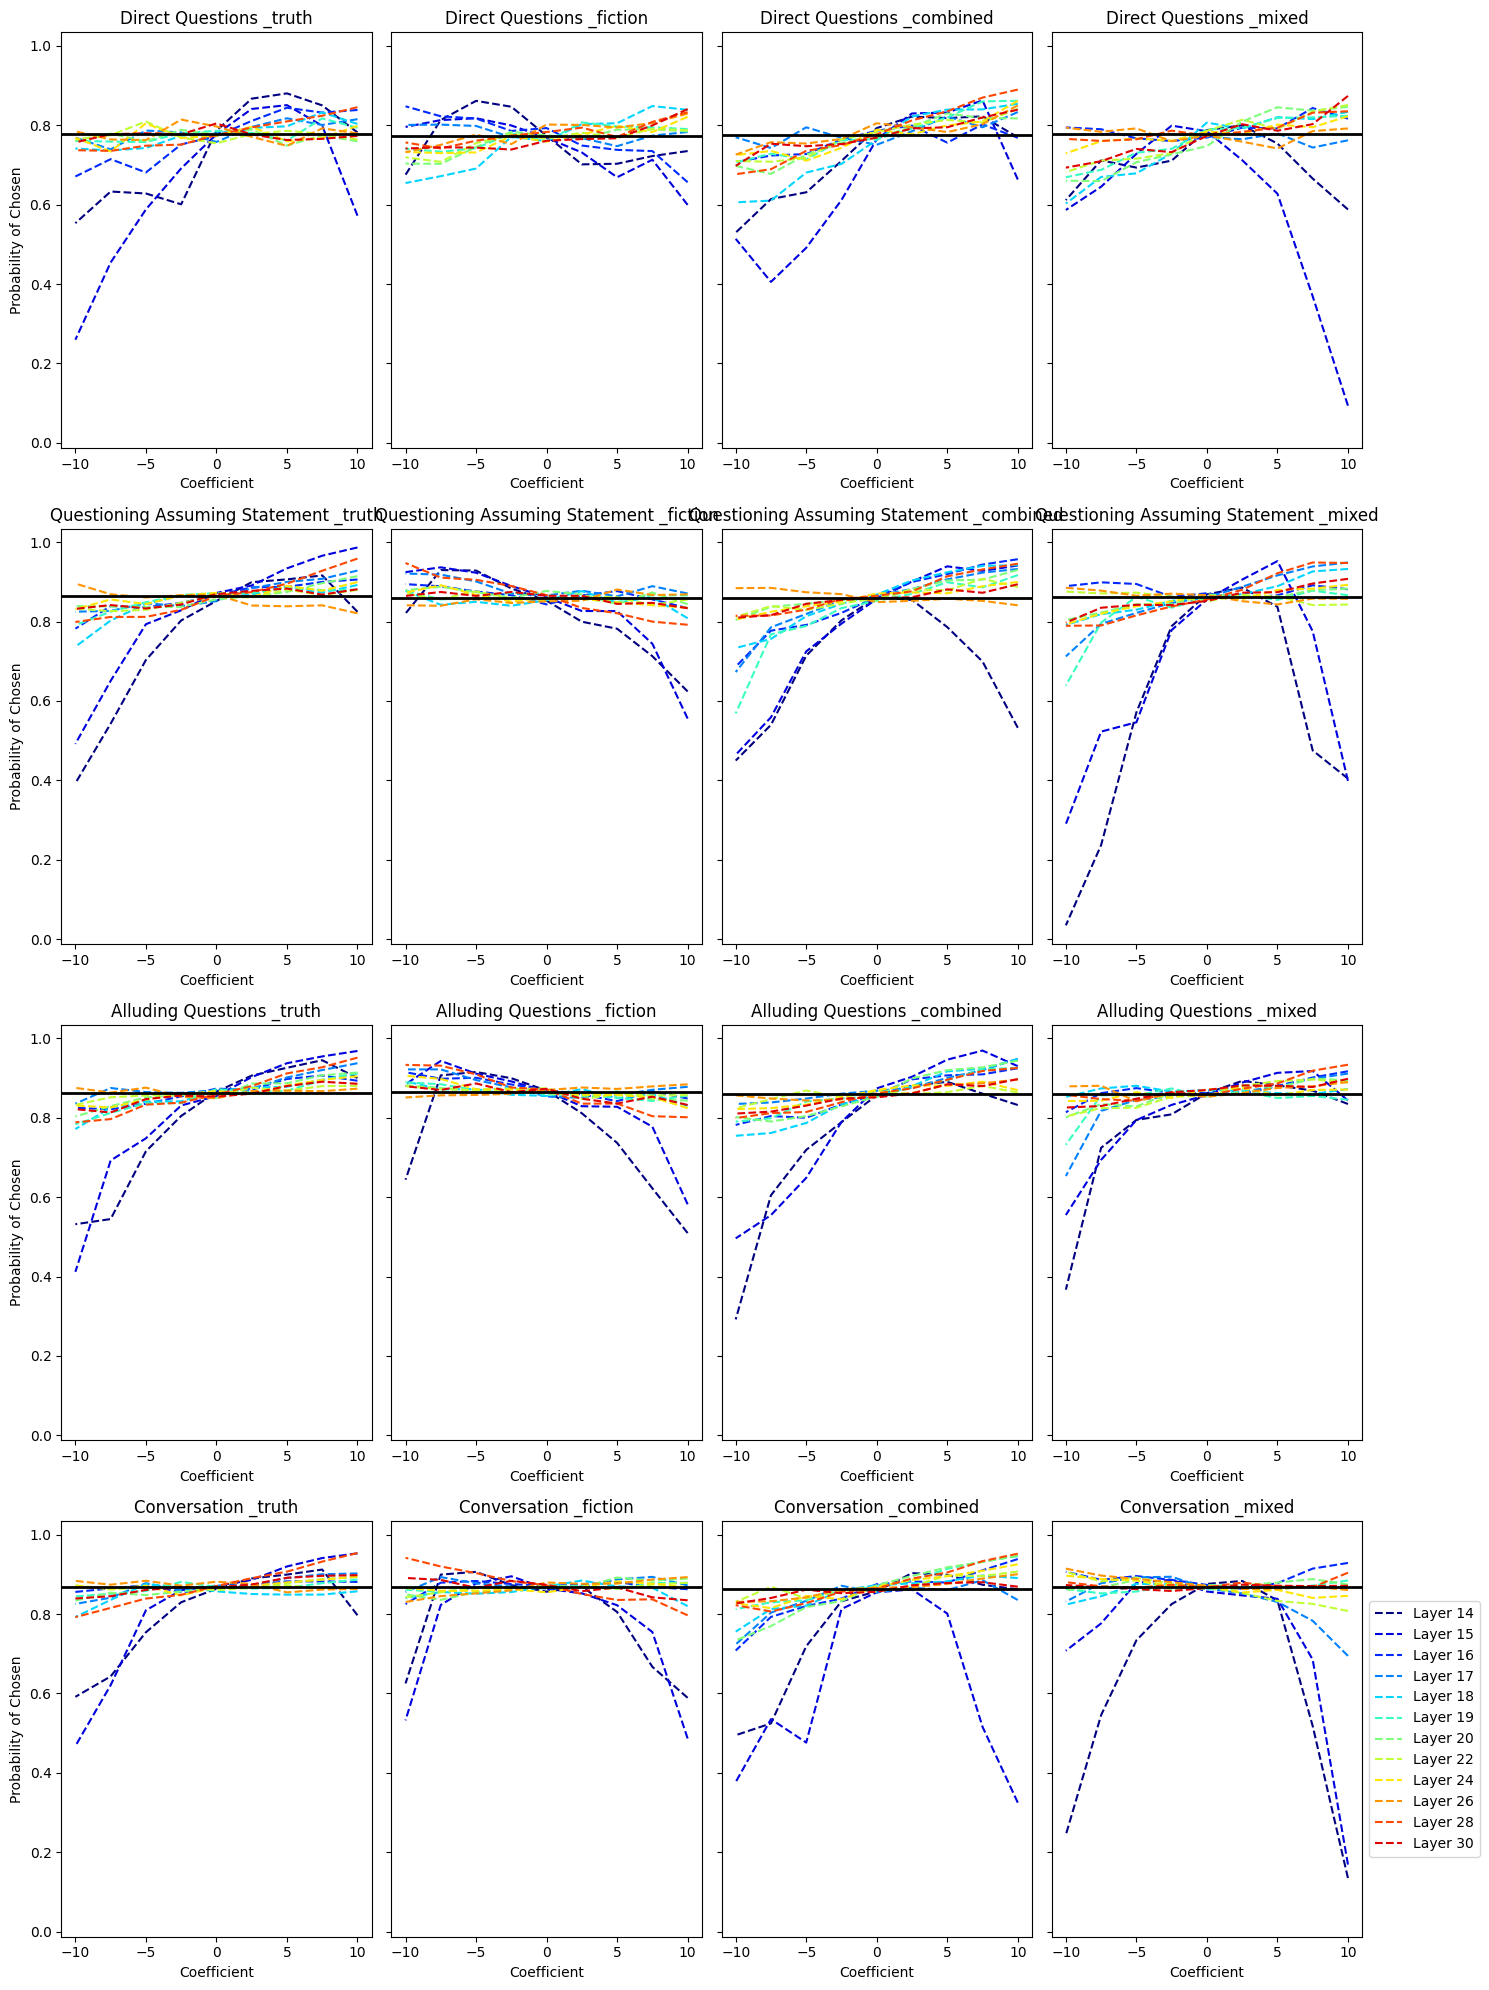

In [8]:
plot_data(all_data_dataframes, coeff_list,layer_list, "truth", data_titles)

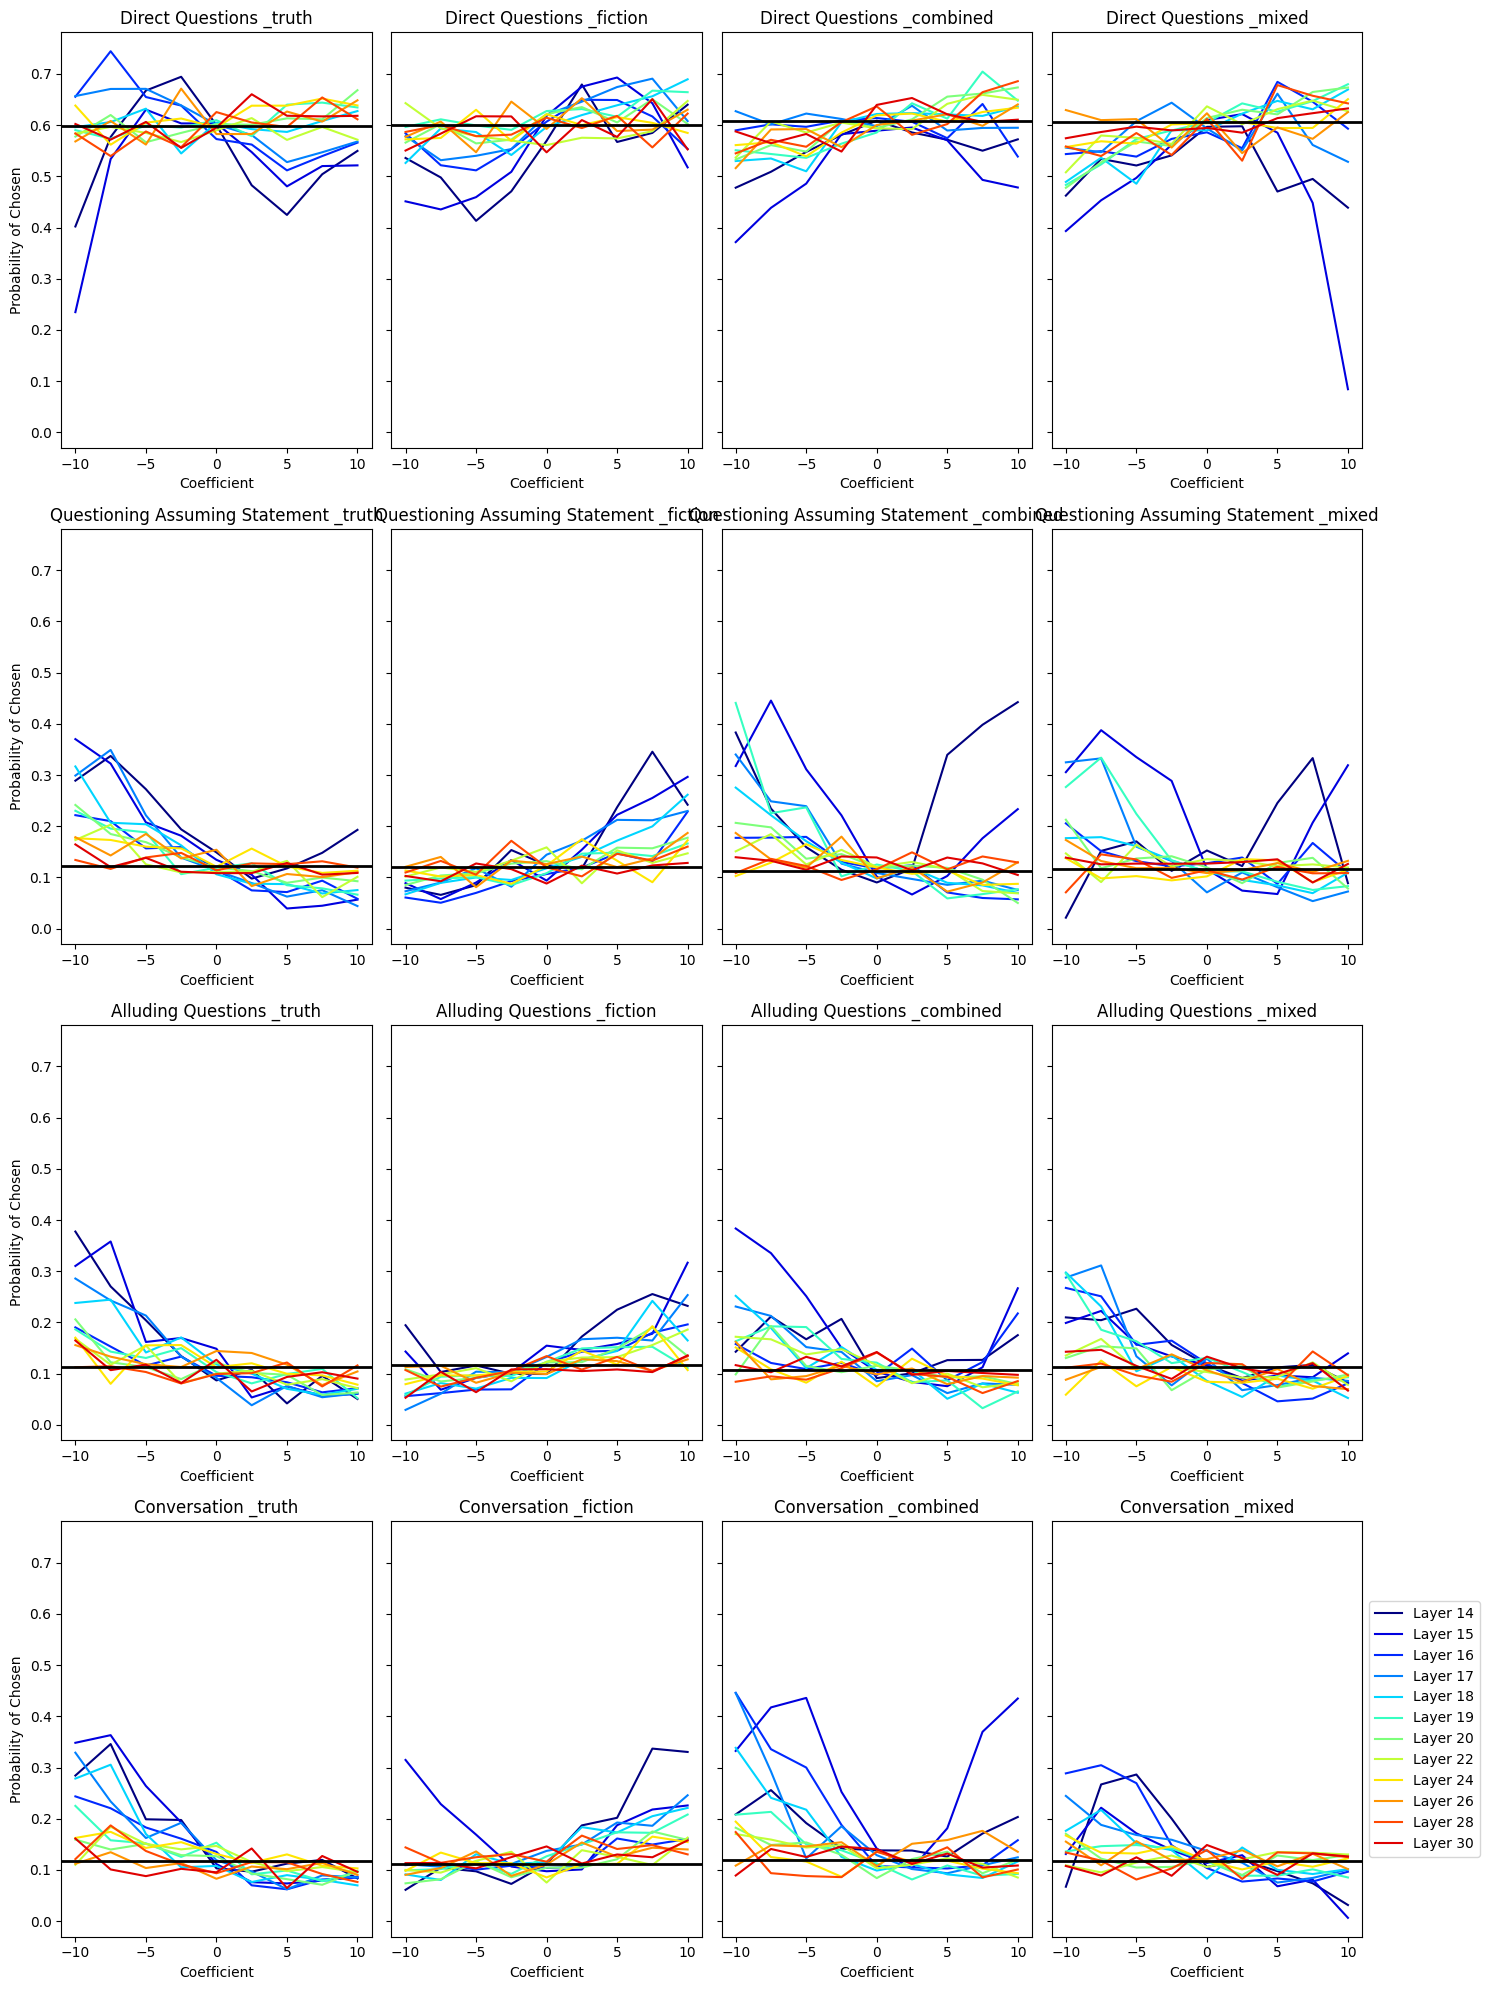

In [9]:
plot_data(all_data_dataframes, coeff_list,layer_list, "fiction", data_titles)


In [10]:

def plot_data_v2(all_data_dfs, coeff_list, layer_list, prob_type, row_titles, col_titles, main_title=None):
    # Exclude "_truth" from steering types
    steering_types = ["_fiction", "_combined", "_mixed"]
    scaling_factor= 0.5

    fig, axes = plt.subplots(len(all_data_dfs), len(steering_types), figsize=(15*scaling_factor, 5 * len(all_data_dfs)*scaling_factor), sharey=True)

     # Check if main_title is provided and set it
    if main_title:
        fig.suptitle(main_title, fontsize=16, y=1.05)  # Adjust fontsize and y for positioning as required

    for j, data_df in enumerate(all_data_dfs):
        for l, steering_type in enumerate(steering_types):
            ax = axes[j][l] if len(all_data_dfs) > 1 else axes[l]
            avg_standard_list = []

            for i, layer in enumerate(layer_list):
                # Retrieve the data from the dataframe
                chosen_type = "chosen" if prob_type == "truth" else "rejected"
                filtered_data = data_df.loc[layer, :, prob_type, chosen_type, steering_type]
                line_style = '--' if prob_type == "truth" else '-'
                ax.plot(coeff_list[::-1], filtered_data['value'].values, label=f'Layer {layer}', linestyle=line_style, color=plt.cm.jet(i / len(layer_list)))

                if l == 0:
                    ax.set_ylabel("Probability")
                avg_standard_list.append(filtered_data.loc[0]['value'])

            avg_standard = np.mean(avg_standard_list)
            ax.axhline(y=avg_standard, color='black', linewidth=2, label='no change' )

            # Set column and row titles
            if j == 0:
                ax.set_title(col_titles[l], fontsize=12)
            if l == 0:
                ax.annotate(row_titles[j], xy=(-0.5, 0.5), xycoords="axes fraction", va="center", ha="center", fontsize=12, rotation=90)

    # Place a legend to the right of this subplot.
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()


In [13]:
col_titles = ["Refusal", "Refusal+Helpfulness ", "Dual-Input Contrast"]
row_titles = ["Direct Question", "Assumption-based Question", "Allusion-based Question", "Conversational Prompt"]

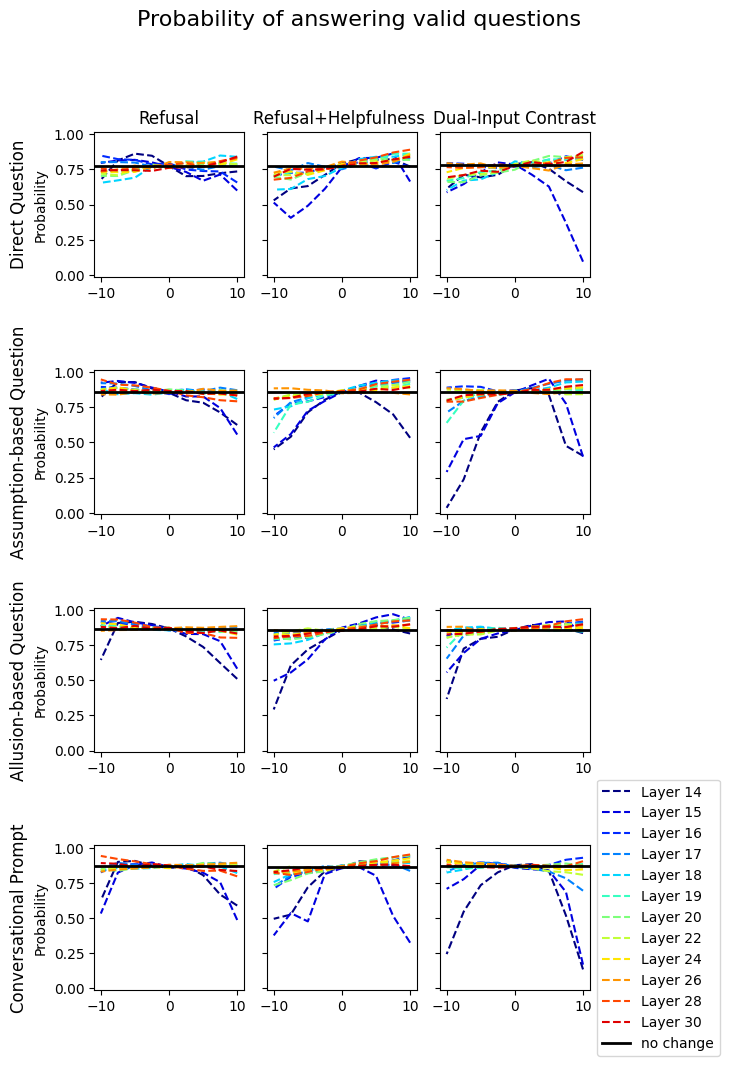

In [14]:
plot_data_v2(all_data_dataframes, coeff_list,layer_list, "truth", row_titles, col_titles, main_title="Probability of answering valid questions")
# Define the path to save the images
data_folder = "./gridsearch_plots"  # Modify this to your specific path
os.makedirs(data_folder, exist_ok=True)
image_name = "truth_data"

plt.savefig(f"{data_folder}/{image_name}.png", format="png", dpi=300, bbox_inches='tight')  # Saving as PNG with higher dpi
plt.savefig(f"{data_folder}/{image_name}.svg", format="svg", bbox_inches='tight')  # Saving as SVG

plt.show()

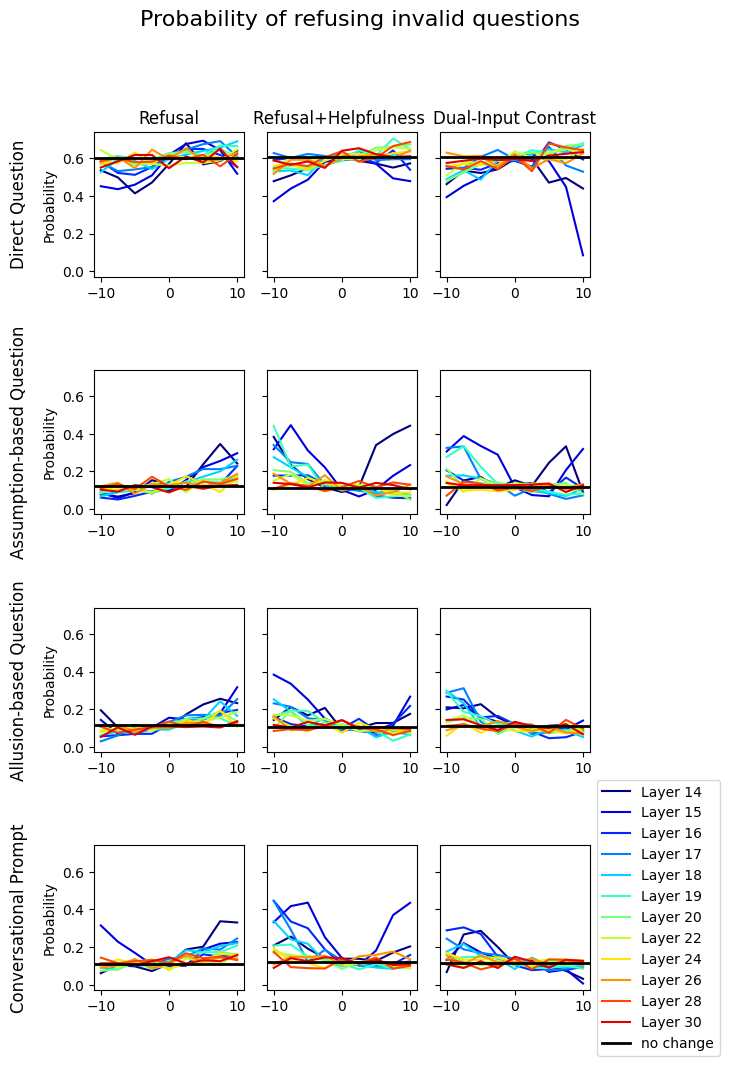

In [15]:
plot_data_v2(all_data_dataframes, coeff_list,layer_list, "fiction", row_titles, col_titles, main_title="Probability of refusing invalid questions")
# Define the path to save the images
data_folder = "./gridsearch_plots"  # Modify this to your specific path
os.makedirs(data_folder, exist_ok=True)
image_name = "fiction_data"
plt.savefig(f"{data_folder}/{image_name}.png", format="png", dpi=300, bbox_inches='tight')  # Saving as PNG with higher dpi
plt.savefig(f"{data_folder}/{image_name}.svg", format="svg", bbox_inches='tight')  # Saving as SVG

plt.show()

In [16]:
import matplotlib.pyplot as plt

def plot_data_v3(all_data_dfs, coeff_list, layer, prob_type, steering_types, row_titles,col_titles, main_title=None):
    colors = ['blue', 'red', 'green', 'orange']

    # Determine the number of subplots needed based on the number of steering types
    num_subplots = len(steering_types)

    # Create a figure and an array of subplots with 1 row and as many columns as there are steering types
    fig, axes = plt.subplots(nrows=1, ncols=num_subplots, figsize=(num_subplots * 4, 4), sharey=True)

    # If only one subplot, wrap axes in a list for consistent indexing
    if num_subplots == 1:
        axes = [axes]
    
    # Adjust the line style based on the prob_type
    line_style = '--' if prob_type == "truth" else '-'

    for ax, steering_type, steering_name in zip(axes, steering_types, col_titles):
        for name, data_df, color in zip(row_titles, all_data_dfs, colors):
            # Retrieve the data from the dataframe
            chosen_type = "chosen" if prob_type == "truth" else "rejected"
            filtered_data = data_df.loc[layer, :, prob_type, chosen_type, steering_type]
            ax.plot(coeff_list[::-1], filtered_data['value'].values, label=name, linestyle=line_style, color=color)
            ax.set_xlabel("Multiplyer")
            if ax == axes[0]:
                ax.set_ylabel("Probability of rejecting invalid questions")

        # Set the title of each subplot to the corresponding steering type
        ax.set_title(steering_name)

    # Set a main title if provided
    if main_title:
        fig.suptitle(main_title)

    # Adjust the layout and place the legend outside of the last axis (subplot)
    fig.tight_layout()  # Adjust the rect to make space for legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.5))

# Example usage:
# plot_data_v3(all_data_dfs, coeff_list, layer, prob_type, steering_types, row_titles, main_title='Your Title Here')


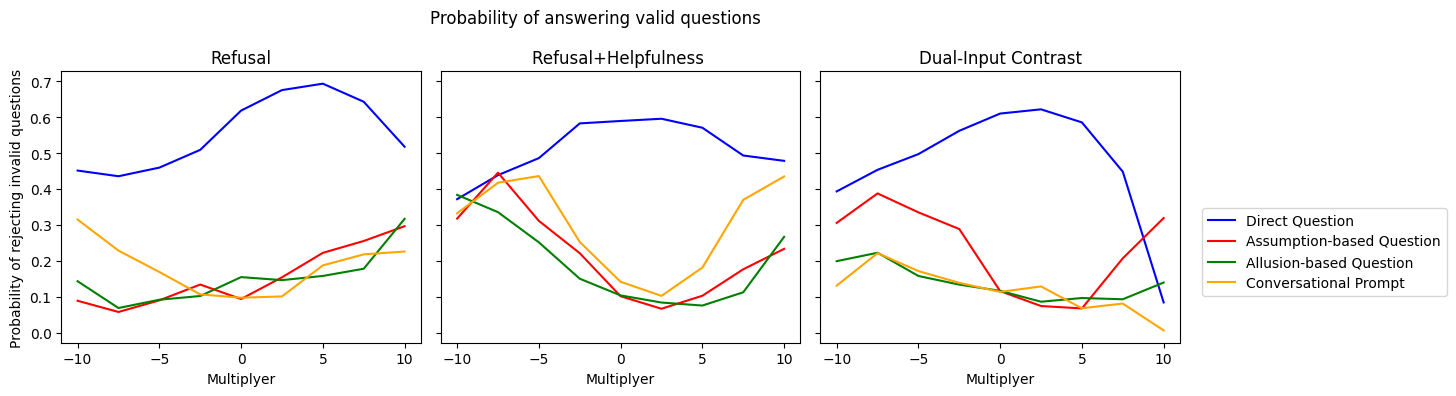

In [17]:
steering_types = ["_fiction", "_combined", "_mixed"]
plot_data_v3(all_data_dataframes, coeff_list, 15, "fiction",steering_types,row_titles,col_titles, main_title="Probability of answering valid questions")

# Define the path to save the images
data_folder = "./gridsearch_plots"  # Modify this to your specific path
os.makedirs(data_folder, exist_ok=True)
image_name = "best_layer_plot"
plt.savefig(f"{data_folder}/{image_name}.png", format="png", dpi=300, bbox_inches='tight')  # Saving as PNG with higher dpi
plt.savefig(f"{data_folder}/{image_name}.svg", format="svg", bbox_inches='tight')  # Saving as SVG


In [27]:
# make now plot_data_v3, but the different steering_types are different plots from left to right

def 

['Direct Question',
 'Assumption-based Question',
 'Allusion-based Question',
 'Conversational Prompt']